Declining  Fertility Rates
Collaborators: John Iglesias

In [248]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import json
import re
import seaborn as sns






pd.set_option("display.max_rows", 20000)


Introduction

The purpose of this project is to walk through a data science pipeline while 
exploring the world's fertility rate trends and its relationship with
global GDP (gross domestic output). Several countries around the globe have
experienced decreasing fertility rates for the past few decades which has
raised some ears

Data Processing

In [171]:
def getAllRegions():
    '''returns mapping of region to region id according to world bank'''
    url = f"http://api.worldbank.org/v2/country/"
    params = {
        "format": "json",
        "date": "1970:2020",
    }
    response = requests.get(url, params=params)
    response_json = response.json()
    regions = {}
    regionsRaw = response_json[1]
    
    for entry in regionsRaw:
        id = entry['region']['id']
        name = entry['region']['value']
        regions[name] = id
    del regions['Aggregates'] #remove aggregates
    return regions
allRegions = getAllRegions()
allRegions

{'Latin America & Caribbean ': 'LCN',
 'South Asia': 'SAS',
 'Sub-Saharan Africa ': 'SSF',
 'Europe & Central Asia': 'ECS',
 'Middle East & North Africa': 'MEA',
 'East Asia & Pacific': 'EAS',
 'North America': 'NAC'}

In [172]:
def parseRegionRow(rawStr):
    '''given an html string, parses string for year,
    and birth rate value, returns tuple'''
    # Extract date
    start = rawStr.find("<wb:date>") + len("<wb:date>")
    end = rawStr.find("</wb:date>", start)
    date = rawStr[start:end].strip()

    # Extract value
    value_pattern = r'<wb:value>(.*?)</wb:value>'
    match = re.search(value_pattern, rawStr)
    value = None
    if match:
        value = float(match.group(1))

    return(date, value)

In [173]:

def parseRegionData(regionID):
    '''retrieves raw string html data for region's birth rate data
    since 1970, returns list of tuples for each year and birth rate'''
    url = f'http://api.worldbank.org/v2/country/{regionID}/indicator/SP.DYN.CBRT.IN?per_page=10000&date=1970:2022'

    # Send an HTTP GET request to the API endpoint
    response = requests.get(url)

    # Extract data from the response
    dataRaw = response.content.decode('utf-8').split('\n')

    #data is in html string format
    rawRegionData = ', '.join(dataRaw)
    rawRegionData = rawRegionData.split("<wb:data>\r,")

    output = []
    for s in rawRegionData:
        output.append(parseRegionRow(s))
    output = output[1:]
    return output




In [174]:

def getRegionBirthRateDF():
    '''returns df for birth rates for each world region from 1970-2022'''
    allDFs = [] #contains each df for each region
    for region in allRegions:
        data = parseRegionData(allRegions[region])
        regionDF = pd.DataFrame([(tup[0], tup[1]) for tup in data], columns=['year', 'birth_rate'])
        #add country column
        regionDF.insert(0, 'region', region)
        allDFs.append(regionDF)
    #combine all dfs
    allDFs = pd.concat(allDFs, ignore_index=True)
    return allDFs

regionBirthRateDF = getRegionBirthRateDF()
regionBirthRateDF.head(10)


,region,year,birth_rate
0,Latin America & Caribbean,2021,NaN
1,Latin America & Caribbean,2020,15.099382
2,Latin America & Caribbean,2019,15.504359
3,Latin America & Caribbean,2018,15.996603
4,Latin America & Caribbean,2017,16.306751
5,Latin America & Caribbean,2016,16.550194
6,Latin America & Caribbean,2015,17.054733
7,Latin America & Caribbean,2014,17.331161
8,Latin America & Caribbean,2013,17.559314
9,Latin America & Caribbean,2012,17.846142


In [195]:
def getCountryBirthRateDF() -> pd.DataFrame:
    ''''returns df of every country's birth rate annually since 1970'''
    # Get a list of all country codes
    url = "http://api.worldbank.org/v2/country/all?per_page=500&format=json"
    response = requests.get(url)
    country_codes = [c['id'] for c in response.json()[1]]

    # Retrieve birth rate data for each country
    data = []
    for country_code in country_codes:
        url = f"http://api.worldbank.org/v2/country/{country_code}/indicator/SP.DYN.CBRT.IN"
        params = {
            "format": "json",
            "date": "1970:2020",
        }
        response = requests.get(url, params=params)
        response_json = response.json()
        # Check if the response is valid before iterating over it
        if len(response_json) > 1:
            if response_json[1]:
                for entry in response_json[1]:
                    data.append({
                        "country": entry["country"]["value"],
                        "date": entry["date"],
                        "birth_rate": entry["value"],
                    })

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data)
    return df


In [196]:
birthCountryDF = getCountryBirthRateDF()


In [197]:
birthCountryDF.head(10)

,country,date,birth_rate
0,Aruba,2020,8.102
1,Aruba,2019,9.138
2,Aruba,2018,9.881
3,Aruba,2017,11.530
4,Aruba,2016,12.300
5,Aruba,2015,12.428
6,Aruba,2014,13.533
7,Aruba,2013,13.316
8,Aruba,2012,12.723
9,Aruba,2011,12.246


In [198]:
allCountries = set()
for country in pycountry.countries:
    allCountries.add(country.name.lower())
    
def isCountry(place):
    '''returns true if place is a country, false ow'''
    return place.lower() in allCountries
       

In [199]:
#remove rows that're not countries
birthCountryDF = birthCountryDF[birthCountryDF['country'].apply(lambda x: isCountry(str(x)))]

#rename date column
birthCountryDF = birthCountryDF.rename(columns={'date': 'year'})

birthCountryDF.head(10)

,country,year,birth_rate
0,Aruba,2020,8.102
1,Aruba,2019,9.138
2,Aruba,2018,9.881
3,Aruba,2017,11.530
4,Aruba,2016,12.300
5,Aruba,2015,12.428
6,Aruba,2014,13.533
7,Aruba,2013,13.316
8,Aruba,2012,12.723
9,Aruba,2011,12.246


In [200]:
def get_gdp_df():
    '''returns df of every country's gdp annually since 1970'''
    url = 'https://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?per_page=20000&date=1970:2022&format=json'
    response = requests.get(url)

    # Extract JSON data from response
    data = response.json()
    df = pd.json_normalize(data[1])

    # get relevant columns
    df = df[['country.value', 'date', 'value']]
    
    # Rename columns
    df.columns = ['country', 'year', 'gdp']


    return df

gdpCountryDF = get_gdp_df()
gdpCountryDF.head(10)








,country,year,gdp
0,Africa Eastern and Southern,2022,NaN
1,Africa Eastern and Southern,2021,1.089454e+12
2,Africa Eastern and Southern,2020,9.341791e+11
3,Africa Eastern and Southern,2019,1.009052e+12
4,Africa Eastern and Southern,2018,1.016697e+12
5,Africa Eastern and Southern,2017,1.030482e+12
6,Africa Eastern and Southern,2016,8.898593e+11
7,Africa Eastern and Southern,2015,9.231439e+11
8,Africa Eastern and Southern,2014,1.003403e+12
9,Africa Eastern and Southern,2013,9.826771e+11


In [201]:
#remove countrues so regions remain
gdpRegionDF = gdpCountryDF[gdpCountryDF['country'].apply(lambda x: not isCountry(str(x)))]
gdpRegionDF = gdpRegionDF.rename(columns={'country': 'region'})



#remove rows that're not countries
gdpCountryDF = gdpCountryDF[gdpCountryDF['country'].apply(lambda x: isCountry(str(x)))]





In [168]:
'''check all regions'''
gdpRegionDF['country'].unique()

array(['Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
       'IDA total', 'Late-demographic dividend',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle in

In [226]:
'''left join regionBirthRateDf with regionGDP df'''

#convert year columns to int
regionBirthRateDF['year'] = regionBirthRateDF['year'].astype(int)
gdpRegionDF['year'] = gdpRegionDF['year'].astype(int)

#remove whitespace from region values
gdpRegionDF = gdpRegionDF.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
regionBirthRateDF = regionBirthRateDF.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

regionDF = regionBirthRateDF.merge(gdpRegionDF, on=['region', 'year'], how='left')
regionDF.head(10)

,region,year,birth_rate,gdp
0,Latin America & Caribbean,2021,NaN,5.454429e+12
1,Latin America & Caribbean,2020,15.099382,4.742372e+12
2,Latin America & Caribbean,2019,15.504359,5.618711e+12
3,Latin America & Caribbean,2018,15.996603,5.702983e+12
4,Latin America & Caribbean,2017,16.306751,5.831864e+12
5,Latin America & Caribbean,2016,16.550194,5.249605e+12
6,Latin America & Caribbean,2015,17.054733,5.372086e+12
7,Latin America & Caribbean,2014,17.331161,6.428177e+12
8,Latin America & Caribbean,2013,17.559314,6.303809e+12
9,Latin America & Caribbean,2012,17.846142,6.152225e+12


In [232]:
'''left join gdp and birth rate tables by gdp for countries'''

#remove whitespace from region values
gdpCountryDF = gdpCountryDF.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
birthCountryDF = birthCountryDF.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

countryDF = gdpCountryDF.merge(birthCountryDF, on=['country', 'year'], how='left')
countryDF.head(10)



,country,year,gdp,birth_rate
0,Afghanistan,2022,NaN,NaN
1,Afghanistan,2021,1.478686e+10,NaN
2,Afghanistan,2020,2.014344e+10,36.051
3,Afghanistan,2019,1.890449e+10,36.466
4,Afghanistan,2018,1.841885e+10,36.927
5,Afghanistan,2017,1.889635e+10,37.342
6,Afghanistan,2016,1.801956e+10,37.936
7,Afghanistan,2015,1.999816e+10,38.803
8,Afghanistan,2014,2.055058e+10,39.105
9,Afghanistan,2013,2.056449e+10,39.601


Exploratory data analysis

    Plot each country's GDP since 1970

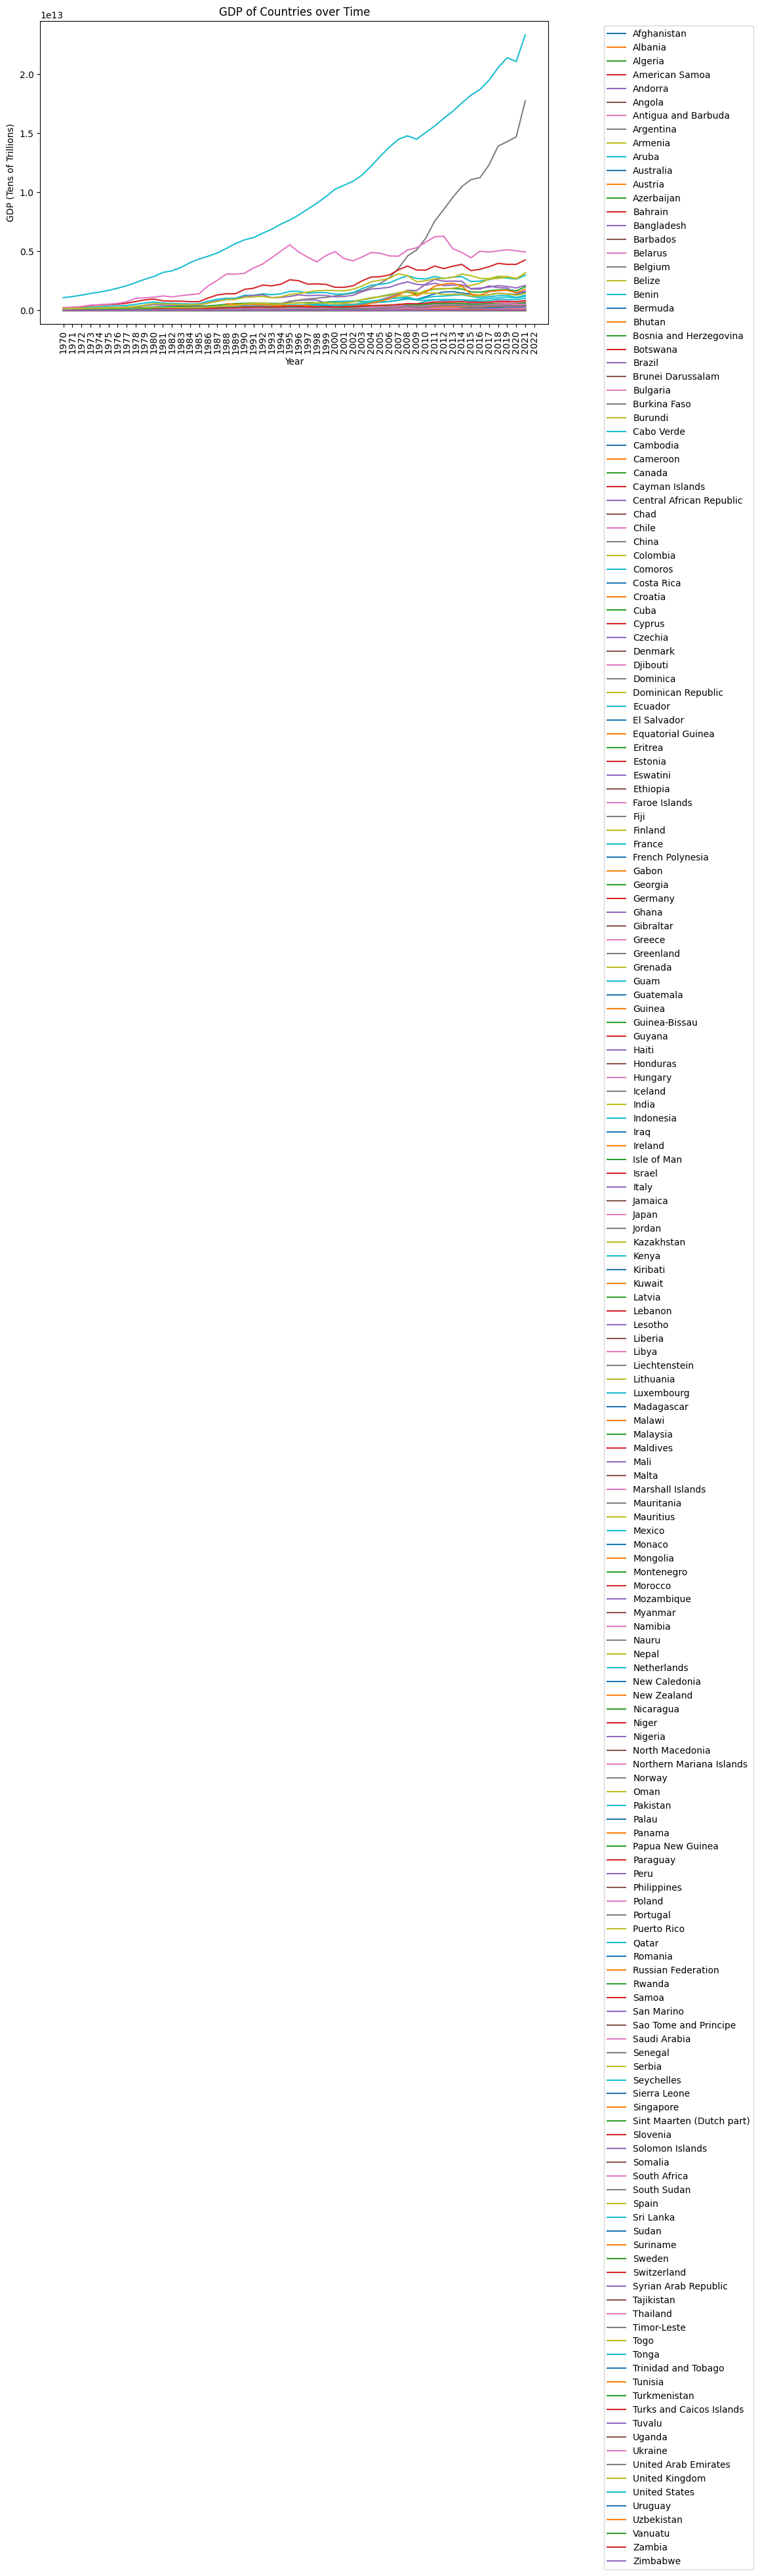

In [233]:
fig, ax = plt.subplots(figsize=(10, 6))

for country in countryDF.country.unique():
    sub_df = countryDF[countryDF.country == country]
    ax.plot(sub_df.year, sub_df.gdp, label=country)

ax.set_xlabel('Year')
ax.set_ylabel('GDP (Tens of Trillions)')
ax.set_title('GDP of Countries over Time')
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
# rotate the x-ticks by 45 degrees
plt.xticks(rotation=90)
# flip the x-axis
ax.invert_xaxis()

plt.show()








As you can see, the US and China are huge GDP outliers since 1970, with the rest
 of the world's GDP staying relatively stagnant under 5  trillion dollars.

Lets instead plot boxplots marking the GDPs for each year in order
to get a better understanding of each year's GDP distribution

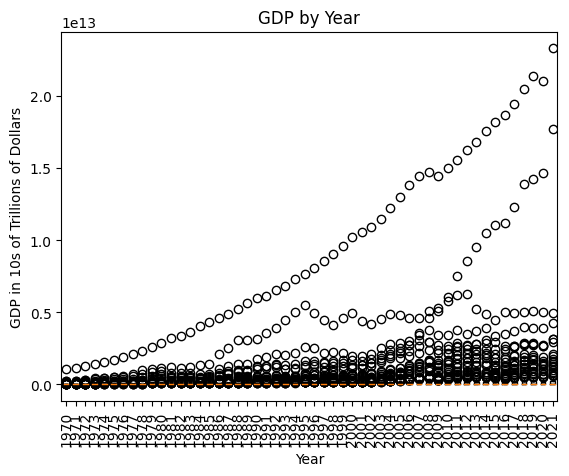

In [58]:

# Filter out rows with missing GDP values
filtered_df = countryDF.dropna(subset=['gdp'])

# Group the data by year
grouped_df = filtered_df.groupby('year')

# Create a list to store the GDP values for each year
data = []

# Iterate over each year and append GDP values to the data list
for year, group in grouped_df:
    data.append(group['gdp'])

# Create a boxplot for each year
plt.boxplot(data)

# Set the x-axis labels to the year values and rotate them by 90 degrees
plt.xticks(range(1, len(grouped_df) + 1), [str(year) for year, _ in grouped_df], rotation=90)

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('GDP in 10s of Trillions of Dollars')
plt.title('GDP by Year')


# Show the plot
plt.show()






We can see that the majority of the world's GDP is increasing relatively slowly
since 1970 as compared to the US and China

Let's visualize the birth rate's for each country annually with a
scatterplot.

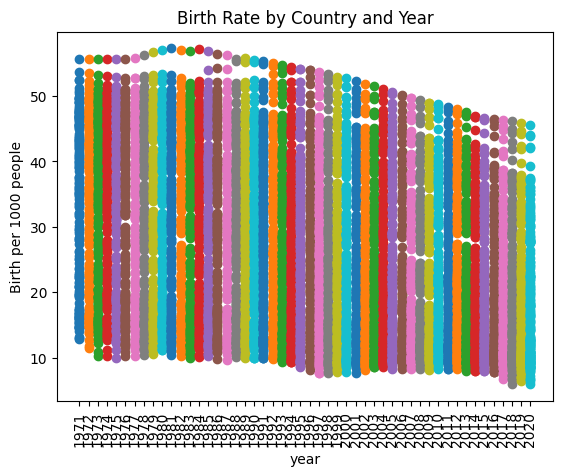

In [53]:
# Filter out rows with missing birth_rate values
filtered_df = countryDF.dropna(subset=['birth_rate'])

# Group the data by year
grouped_df = filtered_df.groupby('year')

# Create a scatterplot for each year
for year, group in grouped_df:
    plt.scatter(group['year'], group['birth_rate'], label=str(year))

# Set the x-axis labels to rotate for better visibility
plt.xticks(rotation=90)

# Add labels and title to the plot
plt.xlabel('year')
plt.ylabel('Birth per 1000 people')
plt.title('Birth Rate by Country and Year')



# Show the plot
plt.show()









We notice a slight trend down year by year in terms of birth rate,
let's try boxplots to better understand the distribution trends

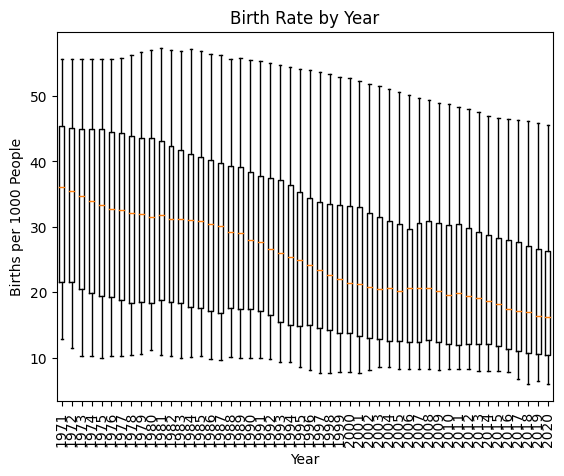

In [51]:

# Filter out rows with missing birth_rate values
filtered_df = countryDF.dropna(subset=['birth_rate'])

# Group the data by year
grouped_df = filtered_df.groupby('year')

# Create a list to store the birth rate values for each year
data = []

# Iterate over each year and append birth rate values to the data list
for year, group in grouped_df:
    data.append(group['birth_rate'])

# Create a boxplot for each year
plt.boxplot(data)

# Set the x-axis labels to the year values
plt.xticks(range(1, len(grouped_df)+1), [str(year) for year, _ in grouped_df], rotation=90)

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Births per 1000 People')
plt.title('Birth Rate by Year')

# Show the plot
plt.show()


We notice a general trend that the world's birth rate 
is decreasing since 1970 from a median of 37 births per 1000 people to 
about 19 births per 10000 people.

Lets plot the GDP by region

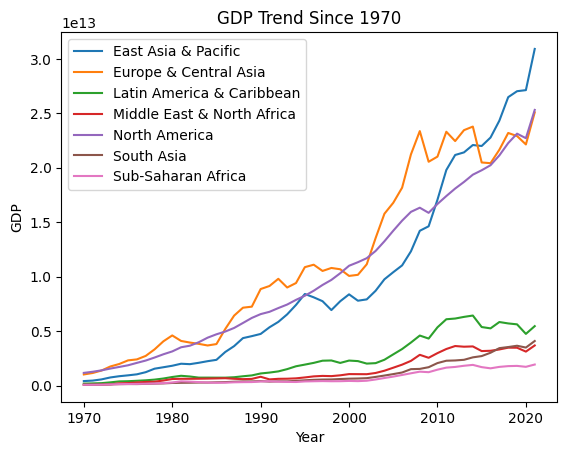

In [63]:
# Filter the DataFrame to include data from 1970 onwards
filtered_df = regionDF[regionDF['year'] >= 1970]

# Group the data by region and iterate over each region
grouped_df = filtered_df.groupby('region')
for region, data in grouped_df:
    plt.plot(data['year'], data['gdp'], label=region)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('GDP in 10s of Trillions of Dollars')
plt.title('GDP By Region')
plt.legend()

# Display the plot
plt.show()

We notice that there is a general trend upwards for GDP for all regions.
However, regions East Asia
& Pacific, Europe & Central Asia, and North America have had the highest 
spike.

Lets check region birth rates.

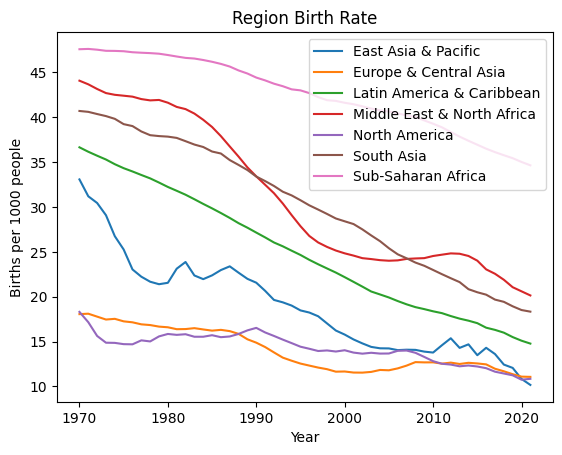

In [65]:
# Filter the DataFrame to include data from 1970 onwards
filtered_df = regionDF[regionDF['year'] >= 1970]

# Group the data by region and iterate over each region
grouped_df = filtered_df.groupby('region')
for region, data in grouped_df:
    plt.plot(data['year'], data['birth_rate'], label=region)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Births per 1000 people')
plt.title('Region Birth Rate')
plt.legend()

# Display the plot
plt.show()


We see that Sub-Saharan Africa has had the highest birth rate since 1970, 
however all regions have had this rate steadily declining

Model: Analysis, Hypothesis Testing, Machine Learning


To test the relationship between region birth rate and GDP, 
we can use a statistical hypothesis test such as Pearson's correlation 
coefficient. The null hypothesis is that there is no 
relationship between birth rate and GDP for each region

In [66]:
import scipy.stats as stats

# Filter the DataFrame to remove missing values
filtered_df = regionDF.dropna(subset=['birth_rate', 'gdp'])

# Perform Pearson's correlation test
correlation, p_value = stats.pearsonr(filtered_df['birth_rate'], filtered_df['gdp'])

# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
print("p-value:", p_value)

Correlation coefficient: -0.6817742213241034
p-value: 4.429289249272849e-51


The correlation coefficient for the data denotes that there is a 
strong negative correlation between GDP and birth rate, however,
the p-value is much higher than 0.05, which is what we would need
it to be in order to reject the null hypothesis and accept that there
is a relationship between both variables

In [67]:
countryDF.head(10)

,country,year,gdp,birth_rate
0,Afghanistan,2022,NaN,NaN
1,Afghanistan,2021,1.478686e+10,NaN
2,Afghanistan,2020,2.014344e+10,36.051
3,Afghanistan,2019,1.890449e+10,36.466
4,Afghanistan,2018,1.841885e+10,36.927
5,Afghanistan,2017,1.889635e+10,37.342
6,Afghanistan,2016,1.801956e+10,37.936
7,Afghanistan,2015,1.999816e+10,38.803
8,Afghanistan,2014,2.055058e+10,39.105
9,Afghanistan,2013,2.056449e+10,39.601


What if we tried to find a correlation with each country as the data
instead of region?

In [68]:
# Filter the DataFrame to remove missing values
filtered_df = countryDF.dropna(subset=['birth_rate', 'gdp'])

# Perform Pearson's correlation test
correlation, p_value = stats.pearsonr(filtered_df['birth_rate'], filtered_df['gdp'])

# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
print("p-value:", p_value)

Correlation coefficient: -0.1984695429796589
p-value: 2.340956083955546e-69


We find there is a much weaker relationship and that the p-value
still does not fit the requirement to reject the null hypothesis.

Lets confirm if there is a negative relationship for region birth rates
using an OLS regression

/var/folders/yk/5t7cp8zj2r95nxxh2thdbq0c0000gn/T/ipykernel_97973/2309682123.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



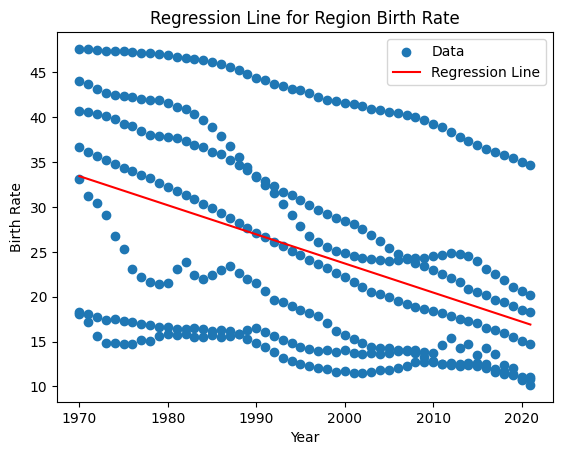

In [69]:
import statsmodels.api as sm

# Filter the DataFrame to remove missing values
filtered_df = regionDF.dropna(subset=['birth_rate'])

# Add a constant column for the intercept term in the regression
filtered_df['intercept'] = 1

# Create the design matrix X and the target variable y
X = filtered_df[['intercept', 'year']]
y = filtered_df['birth_rate']

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the predicted values from the regression model
predicted_values = results.predict(X)

# Plot the data points
plt.scatter(filtered_df['year'], filtered_df['birth_rate'], label='Data')

# Plot the regression line
plt.plot(filtered_df['year'], predicted_values, color='red', label='Regression Line')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Birth Rate')
plt.title('Regression Line for Region Birth Rate')
plt.legend()

# Display the plot
plt.show()


In [70]:

# Filter the DataFrame to remove missing values
filtered_df = regionDF.dropna(subset=['birth_rate'])

# Add a constant column for the intercept term in the regression
filtered_df['intercept'] = 1

# Create the design matrix X and the target variable y
X = filtered_df[['intercept', 'year']]
y = filtered_df['birth_rate']

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             birth_rate   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     86.35
Date:                Wed, 10 May 2023   Prob (F-statistic):           1.44e-18
Time:                        20:18:03   Log-Likelihood:                -1353.1
No. Observations:                 364   AIC:                             2710.
Df Residuals:                     362   BIC:                             2718.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    671.7454     69.583      9.654      0.0

/var/folders/yk/5t7cp8zj2r95nxxh2thdbq0c0000gn/T/ipykernel_97973/2823060365.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The regression coefficent has a slope of -0.3240 which is a 
significant negative slope for birth rates over time.
The coefficient is statistically significant (P < 0.001), 
indicating that the relationship between year and birth_rate 
is unlikely to be due to chance.

Lets run an OLS regression on the region GDPs

/var/folders/yk/5t7cp8zj2r95nxxh2thdbq0c0000gn/T/ipykernel_97973/3347535717.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



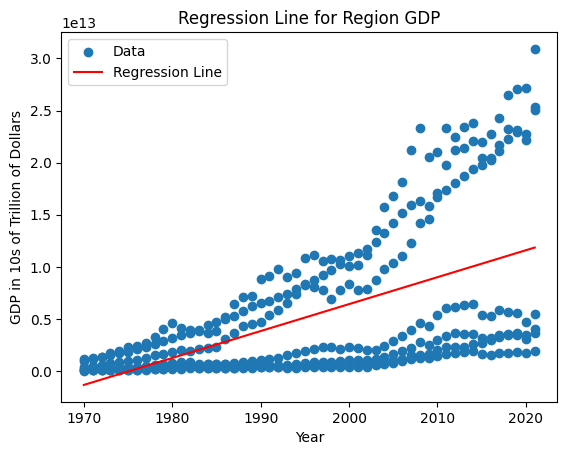

In [71]:
# Filter the DataFrame to remove missing values
filtered_df = regionDF.dropna(subset=['gdp'])

# Add a constant column for the intercept term in the regression
filtered_df['intercept'] = 1

# Create the design matrix X and the target variable y
X = filtered_df[['intercept', 'year']]
y = filtered_df['gdp']

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the predicted values from the regression model
predicted_values = results.predict(X)

# Plot the data points
plt.scatter(filtered_df['year'], filtered_df['gdp'], label='Data')

# Plot the regression line
plt.plot(filtered_df['year'], predicted_values, color='red', label='Regression Line')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('GDP in 10s of Trillion of Dollars')
plt.title('Regression Line for Region GDP')
plt.legend()

# Display the plot
plt.show()


In [72]:
# Filter the DataFrame to remove missing values
filtered_df = regionDF.dropna(subset=['gdp'])

# Add a constant column for the intercept term in the regression
filtered_df['intercept'] = 1

# Create the design matrix X and the target variable y
X = filtered_df[['intercept', 'year']]
y = filtered_df['gdp']

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     165.3
Date:                Wed, 10 May 2023   Prob (F-statistic):           2.04e-31
Time:                        20:23:29   Log-Likelihood:                -11210.
No. Observations:                 364   AIC:                         2.242e+04
Df Residuals:                     362   BIC:                         2.243e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.104e+14   4.01e+13    -12.724      0.0

/var/folders/yk/5t7cp8zj2r95nxxh2thdbq0c0000gn/T/ipykernel_97973/2671725258.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The regression slope is is 2.584e+11. This means that for each one-unit increase
 in the year variable, the predicted value of the gdo variable increases by 
 2.584e+11.
The coefficient is statistically significant (P < 0.001), indicating that the 
relationship between year and gdp is unlikely to be due to chance.

Considering the regression line for GDP is far away from many points,
the line is largely influenced by the outliers of the data set. Let's 
account for these outliers before running our regression using the 
Winsorization technique.

In [ ]:
# # Assuming you have a DataFrame called 'df' with a column named 'gdp'

# # Calculate the lower and upper percentiles for Winsorization
# lower_percentile = 1  # Adjust this as desired
# upper_percentile = 99  # Adjust this as desired

# # Winsorize the 'gdp' column
# df['gdp_winsorized'] = mstats.winsorize(df['gdp'], limits=(lower_percentile/100, upper_percentile/100))

# # Perform your analysis using the 'gdp_winsorized' column instead of the original 'gdp' column
# # ...

# # You can also replace the original 'gdp' column with the winsorized values if desired
# df['gdp'] = df['gdp_winsorized']